In [0]:
!pip install tf-nightly

In [0]:
import tensorflow as tf
print("Tensor Flow Verion: " + tf.__version__)
tf.test.gpu_device_name()

Tensor Flow Verion: 2.2.0-dev20200422


'/device:GPU:0'

In [95]:
!pip install kaggle
!mkdir .kaggle
import json
token = {"username":"mingzhehu","key":"92235045fd85f95ca75fb5844cc352ff"}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /content/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/kermany2018 -p /content

mkdir: cannot create directory ‘.kaggle’: File exists
- path is now set to: {/content}
  6% 629M/10.8G [00:05<01:27, 125MB/s]
User cancelled operation


In [96]:
!unzip \*.zip

Archive:  kermany2018.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of *.zip or
        *.zip.zip, and cannot find kermany2018.zip.ZIP, period.

No zipfiles found.


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import ELU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import numpy as np
import os
import cv2
from os import listdir
from os.path import isfile, join
import re
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model
import matplotlib.image as mpimg
%matplotlib inline

**Load the model**

In [98]:
cd /content/drive/My Drive/Detecting Retina Damage from Speckle Noise Polluted OCT-Retinal Images

/content/drive/My Drive/Detecting Retina Damage from Speckle Noise Polluted OCT-Retinal Images


In [0]:
model = tf.keras.models.load_model('CNN5/saved_model/CNN5_model')

**Add noise to test data**

Noise free

In [0]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [173]:
cd /content

/content


In [0]:
train_data_dir = 'OCT2017 /train'
validation_data_dir = 'OCT2017 /test'

In [0]:
num_classes = 4
img_rows, img_cols = 224, 224
batch_size = 16
nb_train_samples = 83484
nb_validation_samples = 968

In [176]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [177]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 3s 47ms/step - loss: 0.2219 - accuracy: 0.9380

Test result: 93.802 loss: 0.222


In [0]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [179]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


In [0]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()} 
classes = list(class_labels.values())

In [0]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)

Confusion Matrix
[[239   2   1   0]
 [ 21 203   4  14]
 [  9   0 233   0]
 [  0   1   8 233]]


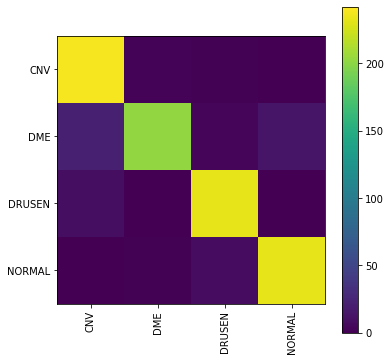

In [182]:
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [183]:
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Classification Report
              precision    recall  f1-score   support

         CNV       0.89      0.99      0.94       242
         DME       0.99      0.84      0.91       242
      DRUSEN       0.95      0.96      0.95       242
      NORMAL       0.94      0.96      0.95       242

    accuracy                           0.94       968
   macro avg       0.94      0.94      0.94       968
weighted avg       0.94      0.94      0.94       968



sigma = 0.01

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=1):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [186]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [187]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 9s 156ms/step - loss: 0.2275 - accuracy: 0.9339

Test result: 93.388 loss: 0.228


In [188]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[238   3   1   0]
 [ 21 203   4  14]
 [  7   0 235   0]
 [  0   1   9 232]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.89      0.98      0.94       242
         DME       0.98      0.84      0.90       242
      DRUSEN       0.94      0.97      0.96       242
      NORMAL       0.94      0.96      0.95       242

    accuracy                           0.94       968
   macro avg       0.94      0.94      0.94       968
weighted avg       0.94      0.94      0.94       968



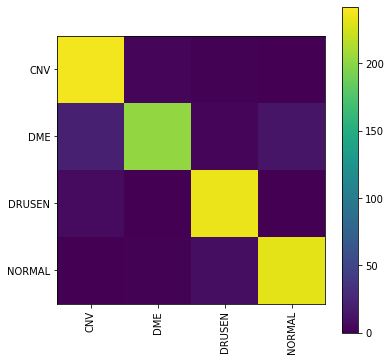

In [189]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

sigma = 0.02

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=1):
  img = img/255.0
  noise = level * np.random.normal(0, 0.02 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [192]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [193]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 10s 156ms/step - loss: 0.2389 - accuracy: 0.9308

Test result: 93.079 loss: 0.239


In [194]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[237   3   2   0]
 [ 21 197   4  20]
 [  7   0 235   0]
 [  0   0   8 234]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.89      0.98      0.93       242
         DME       0.98      0.81      0.89       242
      DRUSEN       0.94      0.97      0.96       242
      NORMAL       0.92      0.97      0.94       242

    accuracy                           0.93       968
   macro avg       0.94      0.93      0.93       968
weighted avg       0.94      0.93      0.93       968



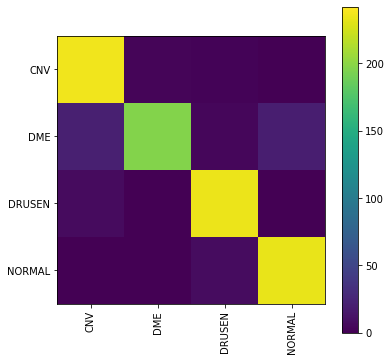

In [195]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

sigma = 0.04

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=1):
  img = img/255.0
  noise = level * np.random.normal(0, 0.04 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [198]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [199]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 9s 155ms/step - loss: 0.2678 - accuracy: 0.9246

Test result: 92.459 loss: 0.268


In [200]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[238   2   2   0]
 [ 23 193   5  21]
 [  7   0 235   0]
 [  0   1  10 231]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.89      0.98      0.93       242
         DME       0.98      0.80      0.88       242
      DRUSEN       0.93      0.97      0.95       242
      NORMAL       0.92      0.95      0.94       242

    accuracy                           0.93       968
   macro avg       0.93      0.93      0.93       968
weighted avg       0.93      0.93      0.93       968



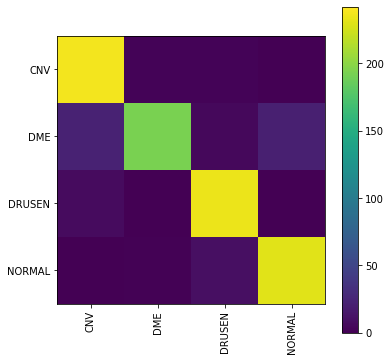

In [201]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

sigma = 0.08

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=1):
  img = img/255.0
  noise = level * np.random.normal(0, 0.08 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [204]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [205]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 9s 156ms/step - loss: 0.3389 - accuracy: 0.8957

Test result: 89.566 loss: 0.339


In [206]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[236   3   3   0]
 [ 32 162  13  35]
 [  6   0 236   0]
 [  0   0  13 229]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.86      0.98      0.91       242
         DME       0.98      0.67      0.80       242
      DRUSEN       0.89      0.98      0.93       242
      NORMAL       0.87      0.95      0.91       242

    accuracy                           0.89       968
   macro avg       0.90      0.89      0.89       968
weighted avg       0.90      0.89      0.89       968



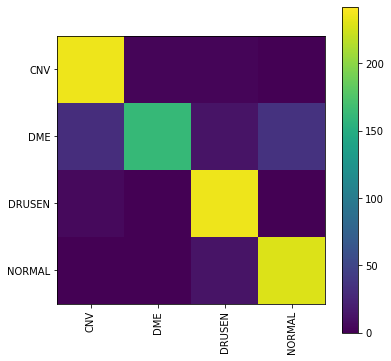

In [207]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

sigma = 0.16

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=1):
  img = img/255.0
  noise = level * np.random.normal(0, 0.16 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [210]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [211]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 9s 155ms/step - loss: 0.5452 - accuracy: 0.8254

Test result: 82.541 loss: 0.545


In [212]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[230   3   8   1]
 [ 38 104  39  61]
 [  6   0 235   1]
 [  0   0  13 229]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.84      0.95      0.89       242
         DME       0.97      0.43      0.60       242
      DRUSEN       0.80      0.97      0.88       242
      NORMAL       0.78      0.95      0.86       242

    accuracy                           0.82       968
   macro avg       0.85      0.82      0.81       968
weighted avg       0.85      0.82      0.81       968



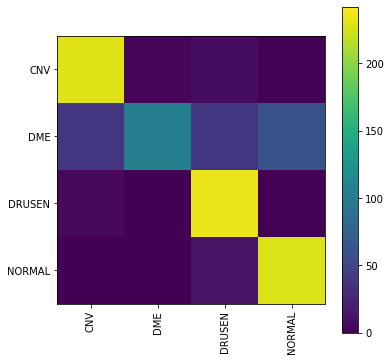

In [213]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

sigma = 0.32

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=1):
  img = img/255.0
  noise = level * np.random.normal(0, 0.32 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [216]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [217]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 10s 158ms/step - loss: 0.9174 - accuracy: 0.7283

Test result: 72.831 loss: 0.917


In [218]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[219   3  16   4]
 [ 63  33  52  94]
 [  6   0 230   6]
 [  0   0  24 218]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.76      0.90      0.83       242
         DME       0.92      0.14      0.24       242
      DRUSEN       0.71      0.95      0.82       242
      NORMAL       0.68      0.90      0.77       242

    accuracy                           0.72       968
   macro avg       0.77      0.72      0.66       968
weighted avg       0.77      0.72      0.66       968



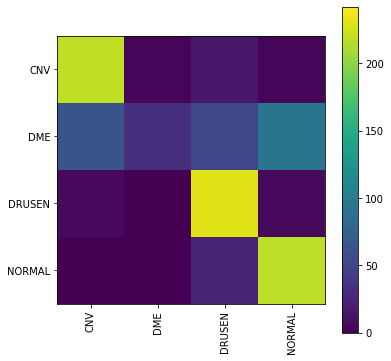

In [219]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Sigma = 0.64

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=1):
  img = img/255.0
  noise = level * np.random.normal(0, 0.64 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [222]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [223]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 10s 158ms/step - loss: 1.3975 - accuracy: 0.6240

Test result: 62.397 loss: 1.397


In [224]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[222   0   8  12]
 [ 95   1  27 119]
 [ 42   0 151  49]
 [  3   0  19 220]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.61      0.92      0.74       242
         DME       1.00      0.00      0.01       242
      DRUSEN       0.74      0.62      0.68       242
      NORMAL       0.55      0.91      0.69       242

    accuracy                           0.61       968
   macro avg       0.72      0.61      0.53       968
weighted avg       0.72      0.61      0.53       968



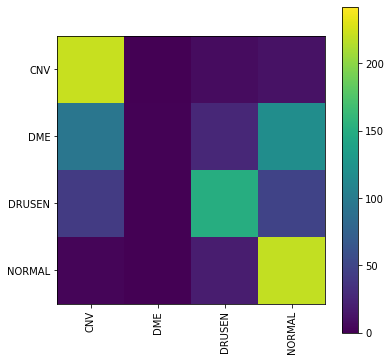

In [225]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

sigma = 1.28

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=1):
  img = img/255.0
  noise = level * np.random.normal(0, 1.28 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [228]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [229]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 10s 160ms/step - loss: 2.2504 - accuracy: 0.4556

Test result: 45.558 loss: 2.250


In [230]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[239   0   0   3]
 [183   0   0  59]
 [186   0   1  55]
 [ 45   0   0 197]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.37      0.99      0.53       242
         DME       0.00      0.00      0.00       242
      DRUSEN       1.00      0.00      0.01       242
      NORMAL       0.63      0.81      0.71       242

    accuracy                           0.45       968
   macro avg       0.50      0.45      0.31       968
weighted avg       0.50      0.45      0.31       968



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


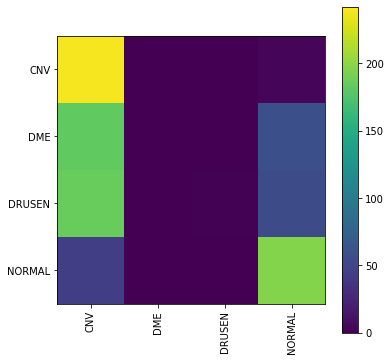

In [231]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))